In [2]:
import argparse
import json
import sys
from abc import ABC
from enum import Enum, unique
from importlib import reload
from itertools import product
from pathlib import Path

import numpy as np
import rasterio
from skimage.color import rgb2gray

sys.path.append("C:/Users/vcritell/pymods/paracelso_wp32")

import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from geopandas import points_from_xy
from matplotlib.colors import LogNorm, PowerNorm
from rasterio import CRS
from rasterio.transform import Affine, AffineTransformer
from skimage.registration import phase_cross_correlation

import ot
import ot.coreg as coreg
import s1
from ot import algoritmi, interfaces, metodi, normalize
from ot.coreg import basic_pixel_coregistration
from ot.helpmsg import (ALGNAME, ATTACHMENT, BAND, FLAGS, FLOW, GAUSSIAN,
                        ITERATIONS, LEVELS, LOGNORM, NODATA, NORMALIZE,
                        NUMITER, NUMWARP, OUTPUT, POLY_N, POLY_SIGMA,
                        PREFILTER, PYR_SCALE, RADIUS, REFERENCE, RGB2GRAY,
                        TARGET, TIGHTNESS, TOL, WINSIZE)

reload(interfaces)
reload(metodi)
reload(algoritmi)
reload(normalize)

<module 'ot.normalize' from 'C:\\Users/vcritell/pymods/paracelso_wp32\\ot\\normalize.py'>

In [108]:
def fname(func, *args, **kwargs):
    def inner(*args, **kwargs):
        print(func.__name__)
        return func(*args, **kwargs)
    return inner


def get_cv_dtype(array):
    dtype_map = {
        'uint8': cv2.CV_8U,
        'int8': cv2.CV_8S,
        'uint16': cv2.CV_16U,
        'int16': cv2.CV_16S,
        'int32': cv2.CV_32S,
        'float32': cv2.CV_32F,
        'float64': cv2.CV_64F
    }
    return dtype_map.get(array.dtype.name, None)


def _normalize_band(band, mask=None, nodata: int | float | None = np.nan):
    if mask is None:
        mask = np.zeros_like(band).astype(bool)
    valid_pixels = band[~mask]
    min_val, max_val = np.min(valid_pixels), np.max(valid_pixels)
    normalized = (band - min_val) / (max_val - min_val)
    normalized[mask] = nodata  # Mantieni NoData
    return normalized


def _zscore_band(band, mask=None, nodata: int | float | None = np.nan):
    if mask is None:
        mask = np.zeros_like(band).astype(bool)
    valid_pixels = band[~mask]
    mean, std = np.mean(valid_pixels), np.std(valid_pixels)
    normalized = (band - mean) / std
    normalized[mask] = nodata
    return normalized


def _log_band(band, mask=None, epsilon=1e-5, nodata: int | float | None = np.nan):
    if mask is None:
        mask = np.zeros_like(band).astype(bool)
    normalized = np.log(band + epsilon)
    normalized[mask] = nodata
    return normalized


def imshow(image, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 9))
    ax.axis('off')
    m = ax.imshow(image.image, filternorm=False, **kwargs)
    plt.colorbar(m, shrink=0.5)


Spostamento: 57.940
SkiOpticalFlowILK  53.585


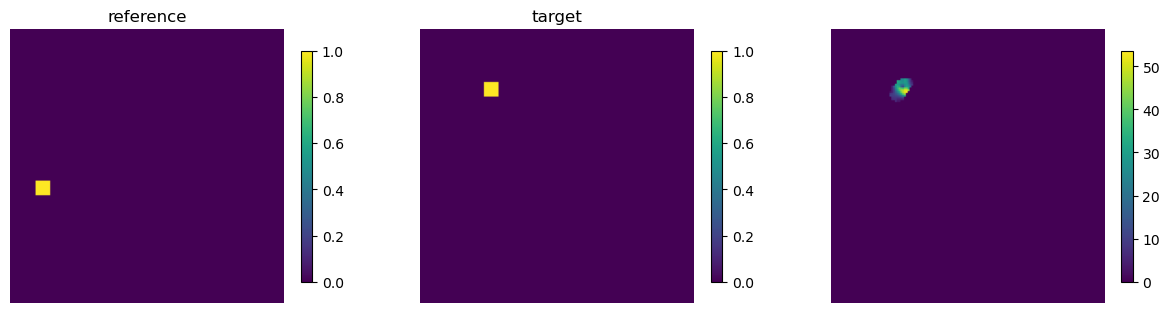

In [310]:
np.random.seed(1235689745)

affine = Affine(10, 0, 0, 0, -10, 954623)
_d = 150
shape = _d, _d

ref = interfaces.Image(np.zeros(shape=shape, dtype=np.uint8), affine=affine, crs='ESPG:32632')
tar = interfaces.Image(np.zeros(shape=shape, dtype=np.uint8), affine=affine, crs='ESPG:32632')

w = 8
sx, sy = np.random.randint(0, _d), np.random.randint(0, 50)
ex, ey = np.random.randint(0, _d), np.random.randint(0, 50)
dx, dy = sx-ex, sy-ey

print(f"Spostamento: {np.linalg.norm([dx, dy]):.3f}")

ref.image[sx:sx+w, sy:sy+w] = 1
tar.image[ex:ex+w, ey:ey+w] = 1

# otm = algoritmi.SkiOpticalFlowTVL1(attachment=1, tightness=1, tol=1e-8, num_iter=25, num_warp=1)
# otm = algoritmi.OpenCVOpticalFlow(flow=False, pyr_scale=0.2, levels=1, winsize=5, iterations=1, flags=None)
otm = algoritmi.SkiOpticalFlowILK(2, 3, 1, 0)
otmap = otm(ref, tar)
print(f"{otm.__class__.__name__} {otmap.image.max(): .3f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
ax1.set_title("reference")
ax2.set_title("target")
imshow(ref, ax=ax1)
imshow(tar, ax=ax2)
imshow(otmap, ax=ax3)

In [80]:
s1file_reference = "../output/D_CL_S1SLC_DFLTB3_168_20240720T045052590968.tif"
s1file_target = "../output/D_CL_S1SLC_DFLTB3_168_20250128T045047807536.tif"
img3 = "C:/Users/vcritell/Pictures/Screenshots/Screenshot 2025-02-04 180759.png"
corvfile2019 = "W:/SoLoMon/Siti/Corvara/DEM/LiDAR_HELICA_2019_2022/Elaborazioni_UNIMORE/IRIS_corvara_2022/Elaborazione_HSD_NCC/processing_2/HSD_2019.tiff"
corvfile2021 = "W:/SoLoMon/Siti/Corvara/DEM/LiDAR_HELICA_2019_2022/Elaborazioni_UNIMORE/IRIS_corvara_2022/Elaborazione_HSD_NCC/processing_2/HSD_2021.tiff"


In [ ]:

c = Image.from_file(img3)
# corv = interfaces.Image.from_file(corvfile2022, nodata=255)

sentinel_reference=interfaces.Image.from_file(s1file_reference)
sentinel_target=interfaces.Image.from_file(s1file_target)

if not sentinel_reference.is_coregistered(sentinel_target):
    basic_pixel_coregistration(s1file_target, s1file_reference, "coreg.tif")
    sentinel_target=interfaces.Image.from_file("coreg.tif")


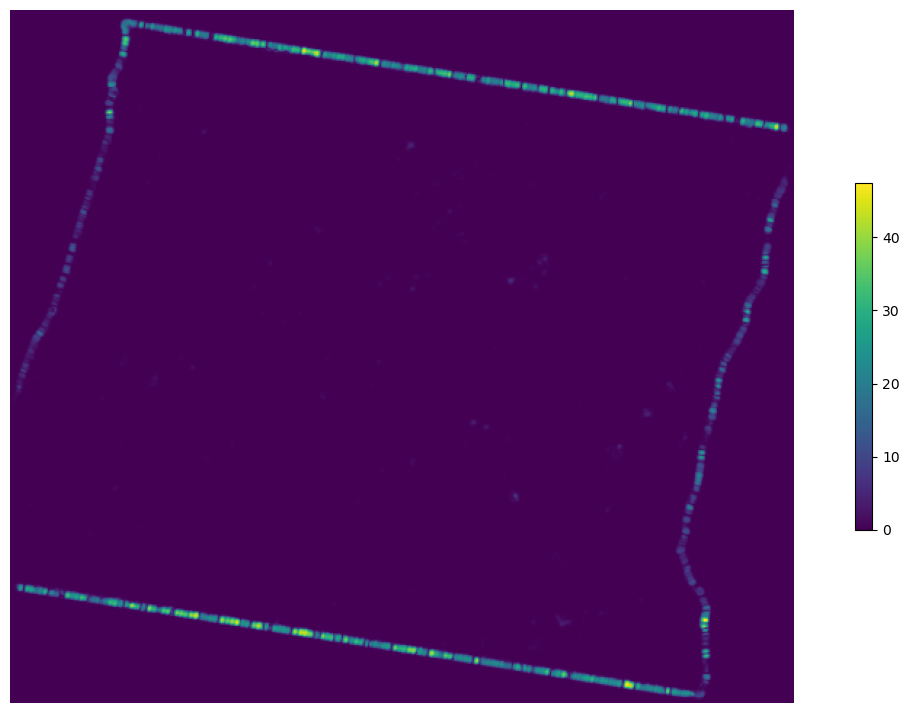

In [181]:

reload(ot.algoritmi)


alg = ot.algoritmi.OpenCVOpticalFlow(winsize=3)
res = alg(sentinel_reference.log_norm().get_band('Green'),
          sentinel_target.log_norm().get_band('Green'))
imshow(res)

In [5]:
bits_fmts = [
    (8, 'U'),
    (8, 'S'),
    (16, 'U'),
    (16, 'S'),
    (16, 'F'),
    (32, 'S'),
    (32, 'F'),
    (64, 'F'),
]

attrs = [f"CV_{bits}{fmt}" for bits, fmt in bits_fmts]
codes = [cv2.__getattribute__(attr) for attr in attrs]

dict(zip(attrs, codes))

{'CV_8U': 0,
 'CV_8S': 1,
 'CV_16U': 2,
 'CV_16S': 3,
 'CV_16F': 7,
 'CV_32S': 4,
 'CV_32F': 5,
 'CV_64F': 6}

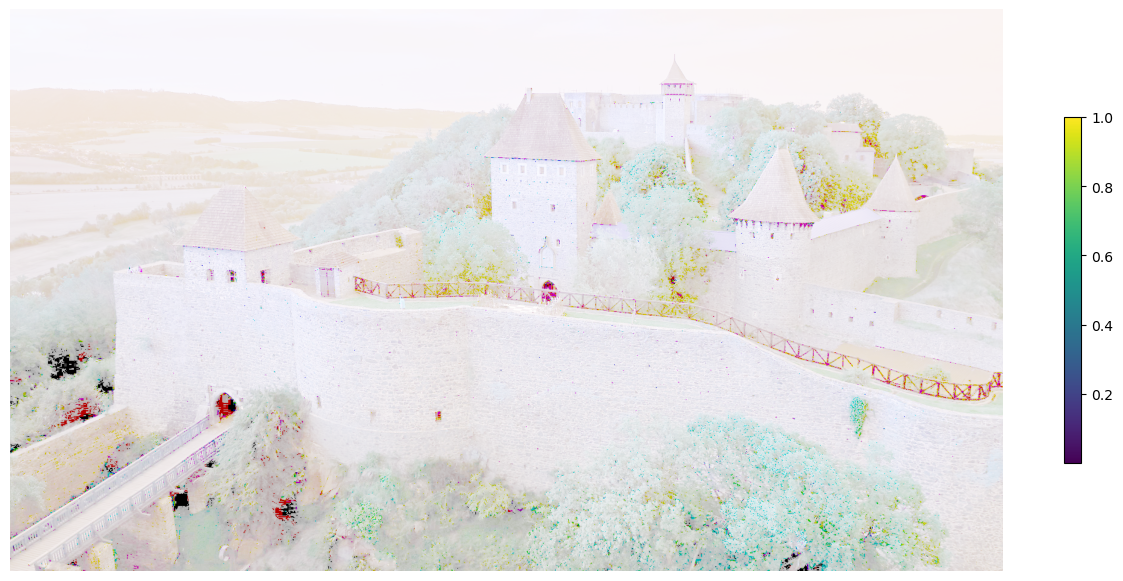

In [185]:
imshow(c.log_norm()._normalize(dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))

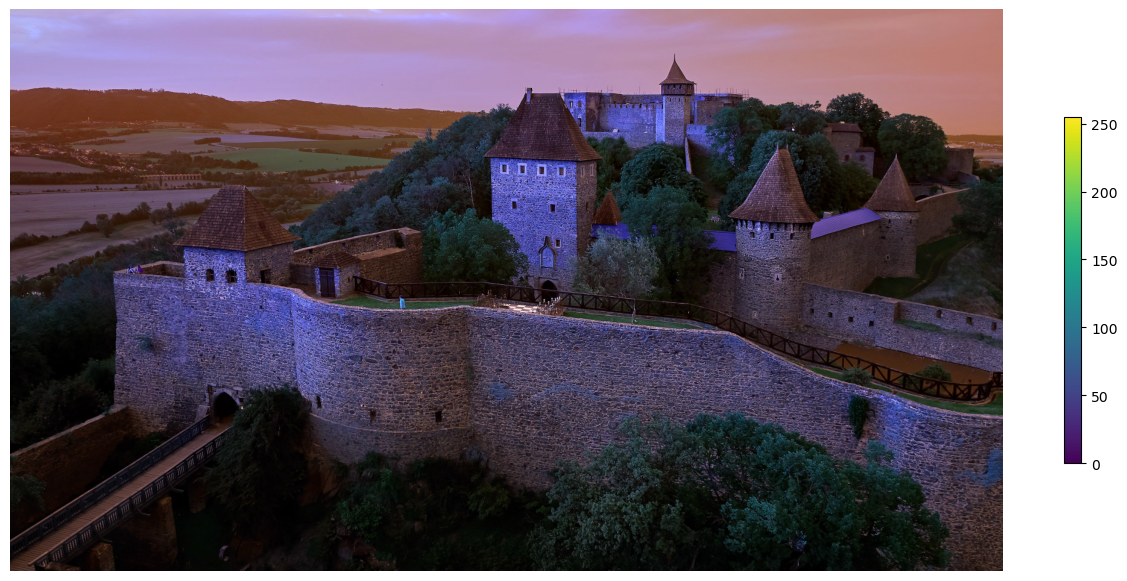

In [186]:
imshow(c)

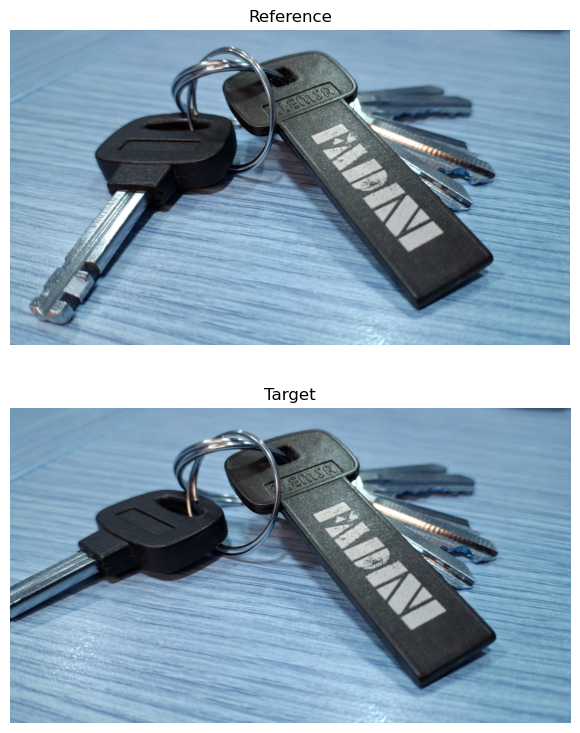

In [6]:
random_file = "C:\\Users\\vcritell\\Pictures\\Screenshots\\Screenshot 2025-02-04 180759.png"
ref = "C:\\Users\\vcritell\\Pictures\\reference1.jpg"
tar = "C:\\Users\\vcritell\\Pictures\\target1.jpg"

reference = interfaces.Image.from_file(ref)
target = interfaces.Image.from_file(tar)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(32, 9))
ax1.axis('off')
ax1.set_title('Reference')
ax2.set_title('Target')
ax2.axis('off')
ax1.imshow(reference.image)
ax2.imshow(target.image)


<class 'ot.interfaces.Image'>


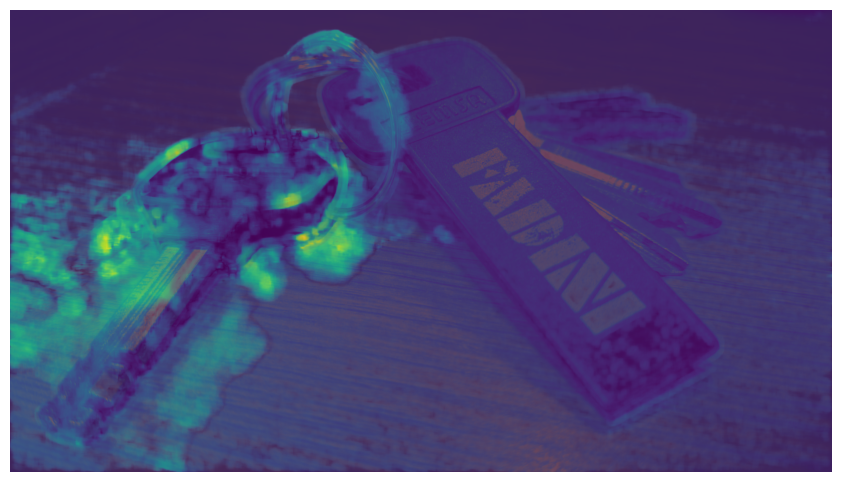

In [188]:
meta = dict()
meta['transform'] = Affine(1,0,0,0,1,0)

offset_tracker = algoritmi.OpenCVOpticalFlow(
    winsize=10, iterations=1, poly_n=5, poly_sigma=1.1,
    flags=ot.algoritmi.OPTFLOW_Flags.OPTFLOW_DEFAULT)

a = offset_tracker(
    reference=reference.to_single_band(),
    target=target.to_single_band())
print(type(a))
n = 1.5
fig, ax = plt.subplots(figsize=(16/n, 9/n))
ax.set_aspect(1)
ax.axis('off')
ax.imshow(reference.minmax_norm().to_single_band().image)
ax.imshow(a.image, alpha=0.8, cmap='viridis')

In [189]:
offset_tracker = ot.algoritmi.SkiOpticalFlowTVL1()

BAND = "Green"

a = offset_tracker(
    reference=reference.get_band(BAND),
    target=target.get_band(BAND))

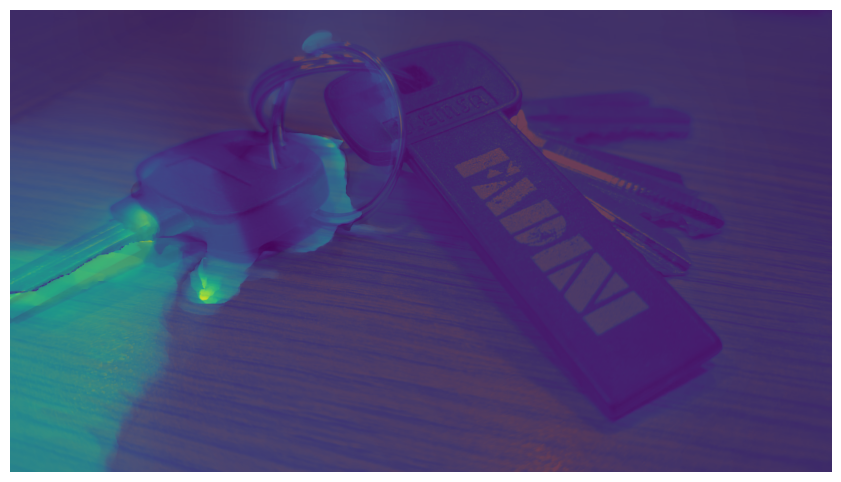

In [190]:
fig, ax = plt.subplots(figsize=(16/n, 9/n))
ax = plt.gca()
ax.set_aspect(1)
ax.axis('off')
ax.imshow(target.get_band(BAND).image)
ax.imshow(a.image, alpha=0.8, cmap='viridis')

In [110]:
reference = interfaces.Image.from_file(corvfile2019)
target = interfaces.Image.from_file(corvfile2021)
offset_tracker = metodi.get_algorithm("SKIPCCV")


In [84]:

k = 16
[(e // k, e % k) for e in reference.shape], [(e // k, e % k) for e in target.shape]


([(375, 0), (625, 0)], [(375, 0), (625, 0)])

In [111]:

a = offset_tracker(win_size=32, step_size=16, upsample_factor = 1.0, phase_norm=False)

df = a(reference=reference.zscore_norm(), target=target.zscore_norm())


<Axes: >

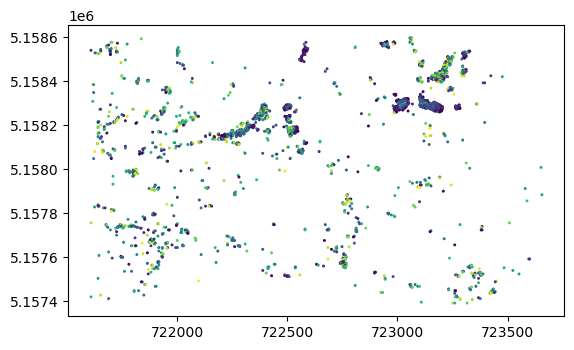

In [112]:
mask = np.logical_and(df.L2 > 2, df.L2 < 4)
df[mask].plot(markersize=5, marker='.', c=df.L2[mask])

In [121]:
375*625

234375

In [134]:
winsize, step_size = 16, 16

for step_size in range(5, 32):
    idx, rws = normalize.stepped_rolling_window(reference.image, (winsize, winsize),
                                                (step_size, step_size))

    print(f"{idx.shape=}")
    print(f"{rws.shape=}")
    print([(e // step_size, e % step_size) for e in reference.shape])

    try:
        assert idx.shape[0] == rws.shape[0]
    except AssertionError:
        print(f"\nErrore con {step_size = }\n{reference.shape[0] // step_size = }\n{reference.shape[1] % step_size = }")


idx.shape=(2396801, 2)
rws.shape=(2390409, 16, 16)
[(1200, 0), (2000, 0)]

Errore con step_size = 5
reference.shape[0] // step_size = 1200
reference.shape[1] % step_size = 0
idx.shape=(1664334, 2)
rws.shape=(1661670, 16, 16)
[(1000, 0), (1666, 4)]

Errore con step_size = 6
reference.shape[0] // step_size = 1000
reference.shape[1] % step_size = 4
idx.shape=(1223796, 2)
rws.shape=(1220085, 16, 16)
[(857, 1), (1428, 4)]

Errore con step_size = 7
reference.shape[0] // step_size = 857
reference.shape[1] % step_size = 4
idx.shape=(935501, 2)
rws.shape=(935501, 16, 16)
[(750, 0), (1250, 0)]
idx.shape=(739926, 2)
rws.shape=(738150, 16, 16)
[(666, 6), (1111, 1)]

Errore con step_size = 9
reference.shape[0] // step_size = 666
reference.shape[1] % step_size = 1
idx.shape=(598401, 2)
rws.shape=(598401, 16, 16)
[(600, 0), (1000, 0)]
idx.shape=(495405, 2)
rws.shape=(494860, 16, 16)
[(545, 5), (909, 1)]

Errore con step_size = 11
reference.shape[0] // step_size = 545
reference.shape[1] % step_size = 